In [1]:
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils.vis_utils import plot_model
from keras.applications.mobilenet_v2 import decode_predictions
from keras.layers.normalization import BatchNormalization

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow
from time import time

import pandas

import pickle as pk

from keras.wrappers.scikit_learn import KerasClassifier

import numpy as np

seed = 7

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib


In [3]:
np.random.seed(seed)

In [4]:
data_dir = '/data/oxford102/train'
train_data_dir = "/data/oxford102/train/"
validation_data_dir = "/data/oxford102/train/"
img_width, img_height = 256, 256
batch_size = 128
epochs = 100
nr_categories = 102
nb_train_samples = 4604
nb_validation_samples = 1094 

In [36]:
def get_image_generator(input_processor, img_aug=False):
    if not img_aug:
        print("no img_aug")
        train_val_datagen = ImageDataGenerator(preprocessing_function=input_processor, 
                                           validation_split=0.2)
    else: 
        print("with img_aug")
        train_val_datagen = ImageDataGenerator(
            rotation_range=90,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            preprocessing_function=input_processor,
            validation_split=0.2)
        
    return train_val_datagen

In [6]:
def get_generators(batch_size, image_size, input_processor, img_aug=False):

    img_width, img_height = image_size
    
    train_val_datagen = get_image_generator(input_processor, img_aug)

    train_generator = train_val_datagen.flow_from_directory(
            train_data_dir,  # this is the target directory
            target_size=(img_width, img_height),  # all images will be resized to 250x250
            batch_size=batch_size,
            subset="training",
            class_mode='categorical')

    validation_generator = train_val_datagen.flow_from_directory(
            train_data_dir,  # this is the target directory
            target_size=(img_width, img_height),  # all images will be resized to 250x250
            subset="validation",
            batch_size=batch_size,
            class_mode='categorical')
    
    return train_generator, validation_generator


In [46]:
#from keras import regularizers

def get_model(network_name="inception_resnet_v2", image_size=(256, 256), verbose=False):
    k.set_learning_phase(0)

    img_width, img_height = image_size
    if network_name == "vgg16":
        base_model = keras.applications.vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
        input_processor = applications.vgg16.preprocess_input
    elif network_name == "vgg19":
        base_model = keras.applications.vgg19.VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
        input_processor = applications.vgg19.preprocess_input
    elif network_name == "inception_resnet_v2":
        base_model = keras.applications.inception_resnet_v2.InceptionResNetV2(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
        input_processor = applications.inception_resnet_v2.preprocess_input
    elif network_name == "mobilenet_v2":
        base_model = keras.applications.mobilenet_v2.MobileNetV2(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
        input_processor = applications.mobilenet_v2.preprocess_input
    elif network_name == "mobilenet":
        base_model = keras.applications.mobilenet.MobileNet(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
        input_processor = applications.mobilenet.preprocess_input
    elif network_name == "xception":
        base_model = keras.applications.xception.Xception(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
        input_processor = applications.xception.preprocess_input
    elif network_name == "resnet50":
        base_model = keras.applications.resnet50.ResNet50(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
        input_processor = applications.resnet50.preprocess_input
    elif network_name == "inception_v3":
        base_model = keras.applications.inception_v3.InceptionV3(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
        input_processor = applications.inception_v3.preprocess_input
    elif network_name == "densenet201":
        base_model = keras.applications.densenet.DenseNet201(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
        input_processor = applications.densenet.preprocess_input
    elif network_name == "nasnet":
        base_model = keras.applications.nasnet.NASNetLarge(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
        input_processor = applications.nasnet.preprocess_input
    else:
        raise Exception("check your network name")

    for layer in base_model.layers[:]:
        layer.trainable = False

        #Adding custom Layers 
    k.set_learning_phase(1)
    x = base_model.output
    x = Flatten()(x)
    x = Dense(1024, activation="relu", 
              #kernel_regularizer=regularizers.l2(0.01),
              #      activity_regularizer=regularizers.l1(0.001)
             )(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x, training=True)
    #x = Dense(102, activation="relu")(x)
    predictions = Dense(nr_categories, activation="softmax")(x)

    _model = Model(input = base_model.input, output = predictions)
       
    if verbose:
        _model.summary()
    return _model, input_processor

In [47]:
def train_model(params, _model, generators):
    model_name = params["network_name"]
    num_train_img = 4604
    num_val_img = 1094

    np.random.seed(seed)
    log_time = time()
    params['log_time'] = log_time
    batch_size = params.get("batch_size")

    train_generator, validation_generator = generators
    _model.compile(loss = "categorical_crossentropy", optimizer = params["optimizer"], metrics=["accuracy"])


    base = '/data/oxford102/experiments'
    path = os.path.join(base, str(log_time))
    checkpoint = ModelCheckpoint(os.path.join(path, "{}_{}.h5".format(model_name, log_time)), monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    early = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')
    tensorboard = TensorBoard(log_dir="logs/{}".format(log_time), histogram_freq=0, write_graph=True, write_images=True)
    csv_logger = CSVLogger(os.path.join(path, "{}_{}.csv".format(model_name, log_time)), append=True, separator=';')

    try:
        if not os.path.exists(path):
            os.makedirs(path)
        history_callback = _model.fit_generator(
                train_generator,
                steps_per_epoch=num_train_img // params["batch_size"] // 2,
                epochs=params["epochs"],
                validation_data=validation_generator,
                validation_steps=num_val_img // params["batch_size"],
                callbacks = [checkpoint, early, tensorboard, csv_logger])
    except Exception as e:
        raise(e)
    finally:
        params.pop("optimizer")
        pk.dump(params, open("experimental_params/experiments_{}.pk".format(log_time), "wb"), protocol=pk.HIGHEST_PROTOCOL)
        _model.save_weights(os.path.join(path, 'model_{}_weights_final_{}.h5'.format(model_name, log_time)))  # always save your weights after training or during training
        print(params)
        params
    return history_callback

# Train with image augmentation

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


with img_aug
Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 23s 1s/step - loss: 4.3110 - acc: 0.1199 - val_loss: 3.3896 - val_acc: 0.2568

Epoch 00001: val_acc improved from -inf to 0.25684, saving model to /data/oxford102/experiments/1549375637.5146441/vgg19_1549375637.5146441.h5
Epoch 2/100
17/17 [==============================] - 19s 1s/step - loss: 3.2037 - acc: 0.2845 - val_loss: 2.8687 - val_acc: 0.3540

Epoch 00002: val_acc improved from 0.25684 to 0.35404, saving model to /data/oxford102/experiments/1549375637.5146441/vgg19_1549375637.5146441.h5
Epoch 3/100
17/17 [==============================] - 15s 861ms/step - loss: 2.2647 - acc: 0.4524 - val_loss: 2.5441 - val_acc: 0.4244

Epoch 00003: val_acc improved from 0.35404 to 0.42443, saving model to /data/oxford102/experiments/1549375637.5146441/vgg19_1549375637.5146441.h5
Epoch 4/100
17/17 [==============================] - 14s 821ms/st

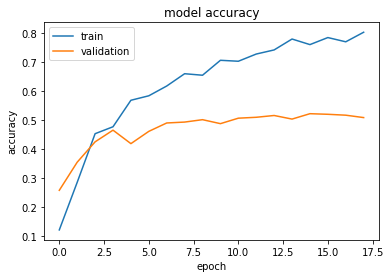

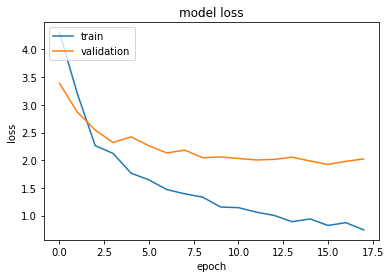

In [10]:
params = {'network_name': "mobilenet",
         'image_aug': True,
         'optimizer_name': "adam", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor, img_aug=params['image_aug'])
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


with img_aug
Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 46s 3s/step - loss: 3.2716 - acc: 0.3153 - val_loss: 2.3996 - val_acc: 0.4590

Epoch 00001: val_acc improved from -inf to 0.45898, saving model to /data/oxford102/experiments/1549376061.8124819/mobilenet_1549376061.8124819.h5
Epoch 2/100
17/17 [==============================] - 34s 2s/step - loss: 1.9829 - acc: 0.5354 - val_loss: 1.5493 - val_acc: 0.6284

Epoch 00002: val_acc improved from 0.45898 to 0.62836, saving model to /data/oxford102/experiments/1549376061.8124819/mobilenet_1549376061.8124819.h5
Epoch 3/100
17/17 [==============================] - 41s 2s/step - loss: 1.1609 - acc: 0.7424 - val_loss: 1.2097 - val_acc: 0.7133

Epoch 00003: val_acc improved from 0.62836 to 0.71325, saving model to /data/oxford102/experiments/1549376061.8124819/mobilenet_1549376061.8124819.h5
Epoch 4/100
17/17 [==============================] - 39s

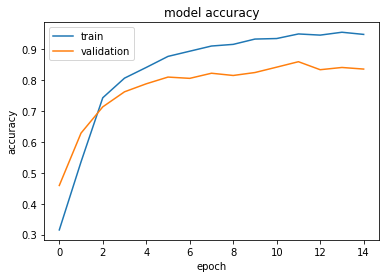

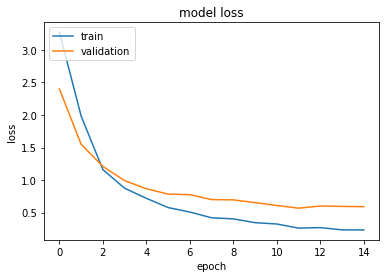

In [12]:
params = {'network_name': "mobilenet",
         'image_aug': True,
         'optimizer_name': "adam", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor, img_aug=params['image_aug'])
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Train without image augmentation

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


no img_aug
Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 18s 1s/step - loss: 2.6073 - acc: 0.4563 - val_loss: 1.6237 - val_acc: 0.6357

Epoch 00001: val_acc improved from -inf to 0.63574, saving model to /data/oxford102/experiments/1549376918.0451467/mobilenet_1549376918.0451467.h5
Epoch 2/100
17/17 [==============================] - 9s 520ms/step - loss: 1.2658 - acc: 0.7165 - val_loss: 0.9438 - val_acc: 0.7961

Epoch 00002: val_acc improved from 0.63574 to 0.79607, saving model to /data/oxford102/experiments/1549376918.0451467/mobilenet_1549376918.0451467.h5
Epoch 3/100
17/17 [==============================] - 14s 832ms/step - loss: 0.3685 - acc: 0.9487 - val_loss: 0.7193 - val_acc: 0.8302

Epoch 00003: val_acc improved from 0.79607 to 0.83023, saving model to /data/oxford102/experiments/1549376918.0451467/mobilenet_1549376918.0451467.h5
Epoch 4/100
17/17 [==============================] - 

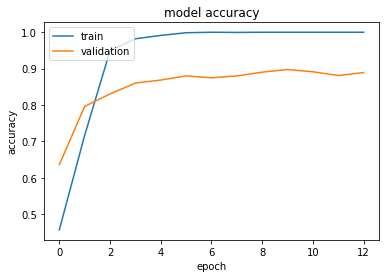

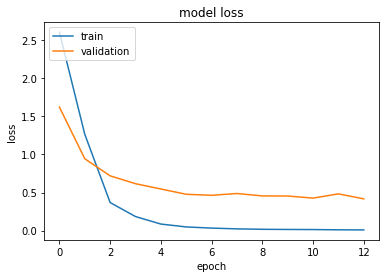

In [13]:
params = {'network_name': "mobilenet",
         'image_aug': False,
         'optimizer_name': "adam", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor, img_aug=params['image_aug'])
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
params = {'network_name': "mobilenet",
         'image_aug': False,
         'optimizer_name': "adam", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor, img_aug=params['image_aug'])



# history = train_model(params, _model, (train_generator, validation_generator))
# # list all data in history
# print(history.history.keys())
# # summarize history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.show()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


with img_aug
Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image.py:1131: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image.py:1139: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


17/17 [==============================] - 41s 2s/step - loss: 2.8582 - acc: 0.3892 - val_loss: 1.9671 - val_acc: 0.5557

Epoch 00001: val_acc improved from -inf to 0.55566, saving model to /data/oxford102/experiments/1549377911.4953938/mobilenet_1549377911.4953938.h5
Epoch 2/100
17/17 [==============================] - 20s 1s/step - loss: 1.5408 - acc: 0.6448 - val_loss: 1.2008 - val_acc: 0.7267

Epoch 00002: val_acc improved from 0.55566 to 0.72671, saving model to /data/oxford102/experiments/1549377911.4953938/mobilenet_1549377911.4953938.h5
Epoch 3/100
17/17 [==============================] - 39s 2s/step - loss: 0.8149 - acc: 0.8208 - val_loss: 0.9506 - val_acc: 0.7743

Epoch 00003: val_acc improved from 0.72671 to 0.77433, saving model to /data/oxford102/experiments/1549377911.4953938/mobilenet_1549377911.4953938.h5
Epoch 4/100
17/17 [==============================] - 38s 2s/step - loss: 0.5768 - acc: 0.8764 - val_loss: 0.7456 - val_acc: 0.8147

Epoch 00004: val_acc improved from 0.

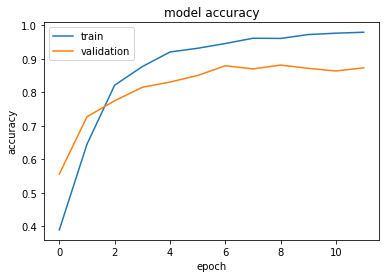

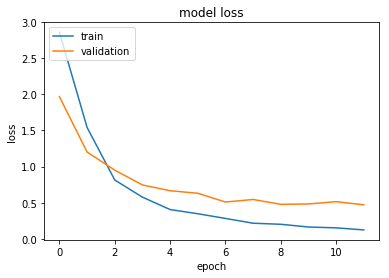

In [25]:
params = {'network_name': "mobilenet",
         'image_aug': True,
         'optimizer_name': "adam", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor, img_aug=params['image_aug'])



history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Plot a few images yielded by the generator with/without augmentation

In [9]:
from matplotlib import pyplot

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


with img_aug
Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image.py:1131: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image.py:1139: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to th

128 128
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


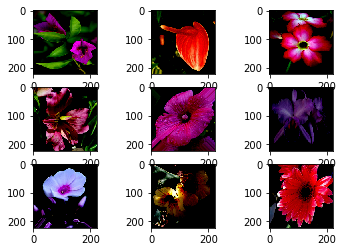

In [56]:
params = {'network_name': "mobilenet",
         'image_aug': True,
         'optimizer_name': "adam", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor, img_aug=params['image_aug'])

for X_batch, y_batch in train_generator:
    # create a grid of 3x3 images
    print(len(X_batch), len(y_batch))
    for i in range(0, 9):
        print(X_batch[i].shape)
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i]) #, cmap=pyplot.get_cmap('gray'))
    # show the plot
    pyplot.show()
    break

In [15]:
from skimage.io import imread 

In [26]:
path = "/data/oxford102/train/garden_phlox"
all_images = []
for image_path in os.listdir(path):
  img = imread(os.path.join("/data/oxford102/train/garden_phlox", image_path) , as_grey=False)
  #img = img.reshape([224, 224, 1])
  all_images.append(img)
x_train = np.array(all_images)

In [38]:
path = "/data/oxford102/train/garden_phlox"

In [18]:
all_images

[array([[0.16429412, 0.16821569, 0.16821569, ..., 0.18669098, 0.18669098,
         0.18669098],
        [0.16429412, 0.16821569, 0.16821569, ..., 0.18669098, 0.18669098,
         0.18669098],
        [0.16821569, 0.16821569, 0.17213725, ..., 0.19061255, 0.19061255,
         0.19061255],
        ...,
        [0.12078235, 0.11826745, 0.11884078, ..., 0.07430392, 0.07794275,
         0.07794275],
        [0.12078235, 0.11826745, 0.11491922, ..., 0.07430392, 0.07794275,
         0.07794275],
        [0.12470392, 0.12218902, 0.11491922, ..., 0.07794275, 0.08158157,
         0.08158157]]),
 array([[0.78076039, 0.77712157, 0.77768706, ..., 0.6572949 , 0.67298118,
         0.68082431],
        [0.7925251 , 0.78496471, 0.7855302 , ..., 0.66345647, 0.69090745,
         0.70659373],
        [0.81241569, 0.80457255, 0.7972949 , ..., 0.67045137, 0.70574549,
         0.7292749 ],
        ...,
        [0.23770039, 0.23770039, 0.24162196, ..., 0.27400471, 0.27400471,
         0.27400471],
        [0.2

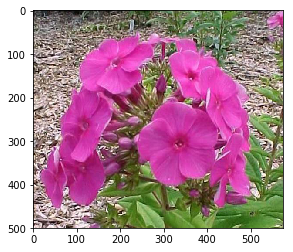

In [30]:
pyplot.imshow(all_images[2], cmap=pyplot.get_cmap('gray'))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


with img_aug
Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


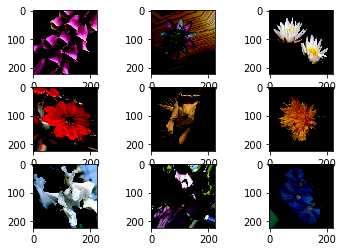

In [33]:
params = {'network_name': "mobilenet",
         'image_aug': True,
         'optimizer_name': "adam", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor, img_aug=params['image_aug'])

for X_batch, y_batch in train_generator:
    # create a grid of 3x3 images
    #print(len(X_batch), len(y_batch))
    for i in range(0, 9):
        #print(X_batch[i].shape)
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i]) #, cmap=pyplot.get_cmap('gray'))
    # show the plot
    pyplot.show()
    break

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


with img_aug
Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


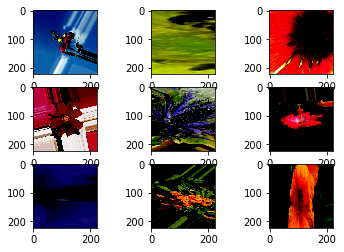

In [35]:
params = {'network_name': "mobilenet",
         'image_aug': True,
         'optimizer_name': "adam", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor, img_aug=params['image_aug'])

for X_batch, y_batch in train_generator:
    # create a grid of 3x3 images
    #print(len(X_batch), len(y_batch))
    for i in range(0, 9):
        #print(X_batch[i].shape)
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i]) #, cmap=pyplot.get_cmap('gray'))
    # show the plot
    pyplot.show()
    break